# GDP ETFs & a Model Portfolio

For this project we will use historical data to compare GDP against Indices(ETF's), we will look at a correlation analysis, a regression analysis, a monte carlo simulation and we will use the historical data to generate three portfolio selections for our client Janice.  

In [1]:
%%capture
# initial imports
import os
import pandas as pd
import seaborn as sns
from pathlib import Path

# “Flight to Safety” analysis
## Correlation of each of the Indices S&P500, Gold, DJIA, NASDAQ, 10_Year.

In [2]:
#load Data gdp_data, indices_data & ETF_data
file_path = Path("Data/market_data_modified.csv")
mkt_data = pd.read_csv(file_path, index_col="Unnamed: 0")
file_path = Path("Data/gdp_data.csv")
gdp_data = pd.read_csv(file_path, index_col="Date")

In [3]:
# clean data
mkt_data.dropna().head()

,S&P500,Gold,DJIA,NASDAQ,10_Year
1/1/1971,95.879997,37.868,93.490000,118.870003,6.09
2/1/1971,96.750000,38.716,101.339996,125.379997,6.14
3/1/1971,100.309998,38.873,105.970001,128.139999,5.53
4/1/1971,103.949997,39.001,112.300003,131.330002,6.08
5/1/1971,99.629997,40.493,108.250000,132.529999,6.38


In [4]:
# concat market data and gdp data
combined_df_indices = pd.concat([mkt_data, gdp_data], axis="columns", join="inner")
# view data head and tail to veryfy concatanation 
combined_df_indices.head(3).append(combined_df_indices.tail(3))

,S&P500,Gold,DJIA,NASDAQ,10_Year,GDP
1/1/1971,95.879997,37.868,93.490000,118.870003,6.090,1135.156
4/1/1971,103.949997,39.001,112.300003,131.330002,6.080,1156.271
7/1/1971,95.580002,40.929,105.269997,127.750000,6.850,1177.675
1/1/2020,3225.520020,1560.668,9150.940430,28256.029300,1.520,21561.139
4/1/2020,2912.429932,1680.030,8889.549805,24345.720700,0.622,19520.114
7/1/2020,3271.120117,1840.807,10745.269530,26428.320310,0.536,21157.635


In [5]:
# Calculate the correlation between each column
correlation = combined_df_indices.corr()
correlation

,S&P500,Gold,DJIA,NASDAQ,10_Year,GDP
S&P500,1.000000,0.782197,0.978638,0.817103,-0.794593,0.950650
Gold,0.782197,1.000000,0.781120,0.679881,-0.652561,0.851478
DJIA,0.978638,0.781120,1.000000,0.879229,-0.728050,0.892884
NASDAQ,0.817103,0.679881,0.879229,1.000000,-0.588278,0.707506
10_Year,-0.794593,-0.652561,-0.728050,-0.588278,1.000000,-0.828459
GDP,0.950650,0.851478,0.892884,0.707506,-0.828459,1.000000


<AxesSubplot:>

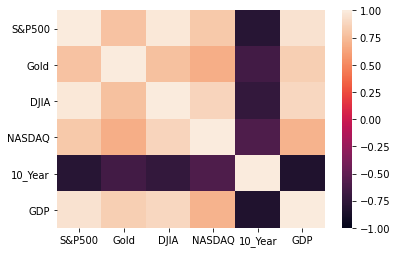

In [6]:
# Use the `heatmap` function from the Seaborn library to visualize correlations
sns.heatmap(correlation, vmin=-1, vmax=1)

## Correlations of each of the ETF's SPY, DIA, QQQ, GLD, IEF.

In [7]:
# additional imports
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

 # Load .env enviroment variables
load_dotenv()

True

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [9]:
# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Set alpaca_api_key and secret
start_date = pd.Timestamp("2004-11-08", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-11-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["SPY","DIA","QQQ","GLD","IEF"]

# Get closing prices for "SPY","DIA","QQQ","GLD","IEF"
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.index=df_ticker.index.date
df_ticker.head()

DIA                                      GLD                \
              open    high     low   close    volume   open   high    low   
2008-01-02  132.47  132.67  129.82  130.38  14555063  83.56  85.14  83.44   
2008-01-03  130.69  131.27  130.13  130.46   7867911  84.87  85.94  84.60   
2008-01-04  129.57  129.73   98.92   98.94  15489641  85.38  85.55  84.43   
2008-01-07   99.06  128.62   98.08  128.26  22119983  85.24  85.26  84.57   
2008-01-08  128.53  129.00   97.05   97.15  23484347  86.25  87.13  86.16   

                             ...    QQQ                                  \
            close    volume  ...   open   high    low  close     volume   
2008-01-02  84.84  11975400  ...  51.27  51.47  50.13  50.41  149569531   
2008-01-03  85.53   9079600  ...  50.39  50.76  50.15  50.43  104746815   
2008-01-04  85.11   7676100  ...  49.79  49.83  48.25  48.28  193237479   
2008-01-07  84.77   6331500  ...  48.41  48.68  47.43  48.17  220176338   
2008-01-08  86.77   8969400  ...  48.29  48.76  46.97  46.98  236721448   

               SPY                                     
              open    high     low   close     volume  
2008-01-02  146.53  146.99  143.88  144.55  175801806  
2008-01-03  144.92  145.49  144.12  144.46  111357758  
2008-01-04  143.34  143.44  140.92  140.93  195945264  
2008-01-07  141.81  142.23  140.10  141.46  220398905  
2008-01-08  142.10  142.90  138.63  138.81  303249870  

[5 rows x 25 columns]

In [10]:
# set variables for indices
dia = df_ticker['DIA']
qqq = df_ticker['QQQ']
gld = df_ticker['GLD']
ief = df_ticker['IEF']
spy = df_ticker['SPY']

In [11]:
# display one of the indices to verify data
dia.head(5)

,open,high,low,close,volume
2008-01-02,132.47,132.67,129.82,130.38,14555063
2008-01-03,130.69,131.27,130.13,130.46,7867911
2008-01-04,129.57,129.73,98.92,98.94,15489641
2008-01-07,99.06,128.62,98.08,128.26,22119983
2008-01-08,128.53,129.00,97.05,97.15,23484347


In [12]:
# Use the `drop` function to delete columns
dia = dia.drop(columns=['low','high','open','volume'])
qqq = qqq.drop(columns=['low','high','open','volume'])
gld = gld.drop(columns=["low", "high","open","volume"])
ief = ief.drop(columns=['low','high','open','volume'])
spy = spy.drop(columns=['low','high','open','volume'])

In [13]:
# display one of the indices to verify data
dia.head()

,close
2008-01-02,130.38
2008-01-03,130.46
2008-01-04,98.94
2008-01-07,128.26
2008-01-08,97.15


In [14]:
#use the 'rename' function to remane close columns
dia = dia.rename(columns={"close": "DIA",})
qqq = qqq.rename(columns={"close": "QQQ",})
gld = gld.rename(columns={"close": "GLD",})
ief = ief.rename(columns={"close": "IEF",})
spy = spy.rename(columns={"close": "SPY",})

In [15]:
# display .head() to verify name change
dia.head()

,DIA
2008-01-02,130.38
2008-01-03,130.46
2008-01-04,98.94
2008-01-07,128.26
2008-01-08,97.15


In [16]:
# concat ETF's
combined_df = pd.concat([spy, gld, qqq, ief, dia], axis="columns", join="inner")
combined_df.head()

,SPY,GLD,QQQ,IEF,DIA
2008-01-02,144.55,84.84,50.41,87.65,130.38
2008-01-03,144.46,85.53,50.43,87.77,130.46
2008-01-04,140.93,85.11,48.28,87.99,98.94
2008-01-07,141.46,84.77,48.17,88.23,128.26
2008-01-08,138.81,86.77,46.98,88.39,97.15


In [17]:
# Calculate the correlation between each column
correlation_etf = combined_df.corr()
correlation_etf

,SPY,GLD,QQQ,IEF,DIA
SPY,1.000000,0.274473,0.973992,0.715407,0.987970
GLD,0.274473,1.000000,0.354762,0.629894,0.273541
QQQ,0.973992,0.354762,1.000000,0.738007,0.959518
IEF,0.715407,0.629894,0.738007,1.000000,0.680622
DIA,0.987970,0.273541,0.959518,0.680622,1.000000


<AxesSubplot:>

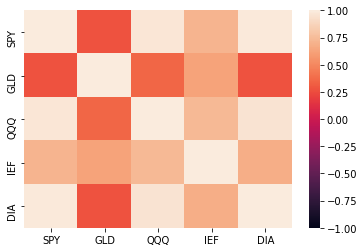

In [18]:
# Use the `heatmap` function from the Seaborn library to visualize correlations
sns.heatmap(correlation_etf, vmin=-1, vmax=1)

# “Flight to Safety” analysis:
Correlation of gold to the s&p500

In [19]:
# display concated data
combined_df_indices.head()

,S&P500,Gold,DJIA,NASDAQ,10_Year,GDP
1/1/1971,95.879997,37.868,93.490000,118.870003,6.09,1135.156
4/1/1971,103.949997,39.001,112.300003,131.330002,6.08,1156.271
7/1/1971,95.580002,40.929,105.269997,127.750000,6.85,1177.675
10/1/1971,94.230003,42.473,105.099998,130.240005,5.87,1190.297
1/1/1972,103.940002,45.640,118.870003,128.399994,6.09,1230.609


In [20]:
# drop columns
gold_sp500 = combined_df_indices.drop(columns=['DJIA','NASDAQ','10_Year','GDP'])
gold_sp500.head()

,S&P500,Gold
1/1/1971,95.879997,37.868
4/1/1971,103.949997,39.001
7/1/1971,95.580002,40.929
10/1/1971,94.230003,42.473
1/1/1972,103.940002,45.640


C:\Users\clear\anaconda3\envs\dev\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'S&P500 & Gold'}>

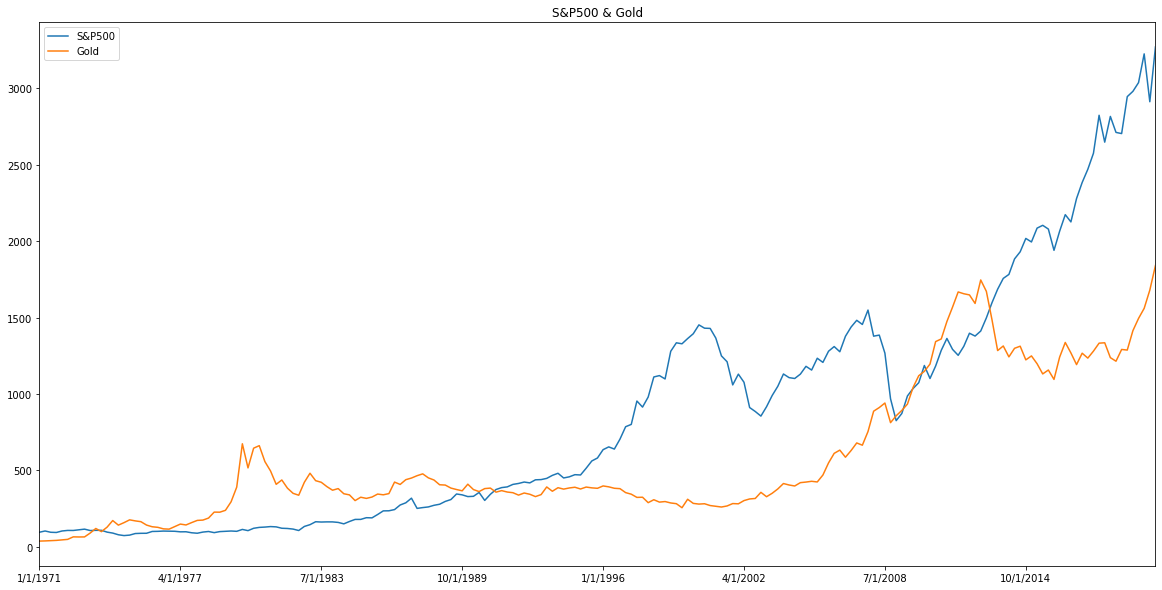

In [21]:
gold_sp500.plot(figsize=(20, 10), title="S&P500 & Gold")

<AxesSubplot:xlabel='Gold', ylabel='S&P500'>

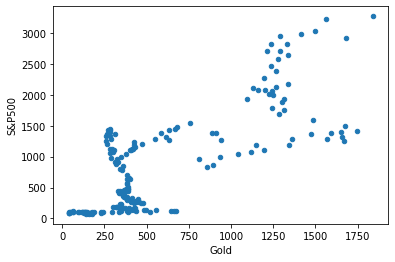

In [22]:
# Plot the relationship between the two variables
gold_sp500.plot(kind='scatter', x='Gold', y='S&P500')

In [23]:
gold_sp500_cor = gold_sp500.corr()
gold_sp500_cor

,S&P500,Gold
S&P500,1.000000,0.782197
Gold,0.782197,1.000000


<AxesSubplot:>

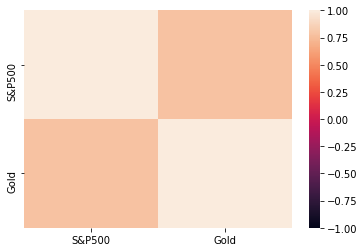

In [24]:
sns.heatmap(gold_sp500_cor, vmin=-1, vmax=1)

### Monte Carlo

In [25]:
%%capture
#Import Libraries
import numpy as np  
import pandas_datareader as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

In [26]:
#Settings for Monte Carlo asset data, how long, and how many forecasts 
ticker = 'GDP' # ticker
t_intervals = 40 # time steps forecasted into future
iterations = 1000 # amount of simulations

In [27]:
#Acquiring data
data = pd.read_csv('Data/gdp_data.csv',index_col=0,usecols=['Date', 'GDP'])
data = data.rename(columns={"Price": ticker}) #.reset_index()

C:\Users\clear\anaconda3\envs\dev\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Historical Closing Prices'}, xlabel='Date'>

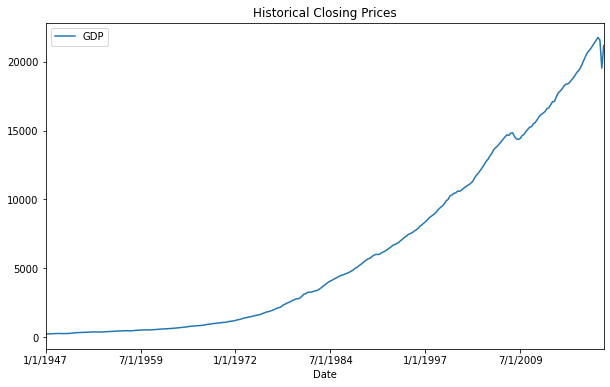

In [28]:
#Plot of asset historical closing price
data.plot(figsize=(10, 6), title='Historical Closing Prices')

In [29]:
#Preparing log returns from data
log_returns = np.log(1 + data.pct_change())

C:\Users\clear\anaconda3\envs\dev\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Log Returns'}, xlabel='Date'>

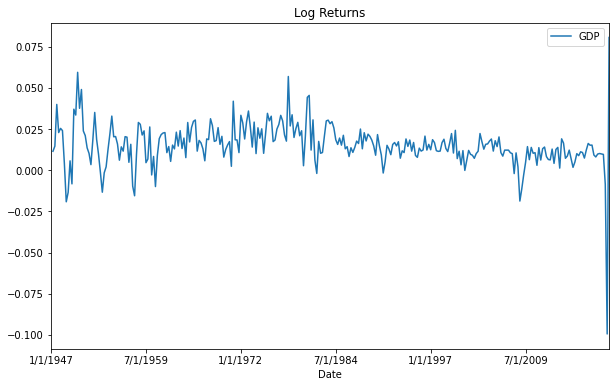

In [30]:
#Plot of log returns
log_returns.plot(figsize = (10, 6), title="Log Returns")

In [31]:
print(round(np.mean(log_returns*100),2)) # GDP Quarterly Average Return

GDP    1.52
dtype: float64


## Monte Carlo Simulation

In [32]:
# additional imports
import math

In [33]:
#set up empty list to hold our ending values for each simulated price series
result = []

#Setting up drift and random component in relation to asset data
u = log_returns.mean() # Return
var = log_returns.var() #Volatility
drift = u - (0.5 * var)
stdev = log_returns.std()

daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

In [34]:
#Takes last data point as startpoint point for simulation
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

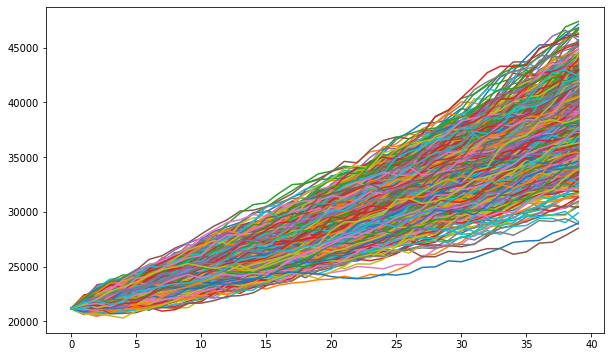

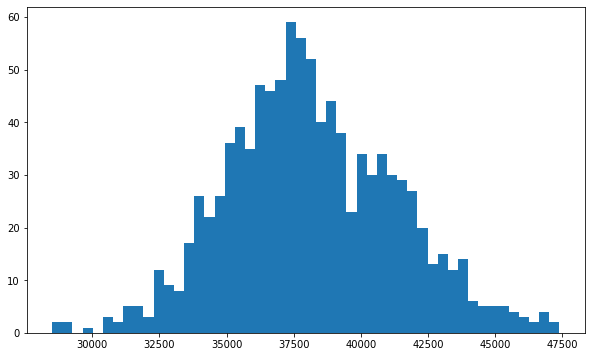

In [35]:
#Applies Monte Carlo simulation in asset
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
    
plt.figure(figsize=(10,6))
plt.plot(price_list)
result.append(price_list[-1])

#show the plot of multiple price series created above
plt.show()

#create histogram of ending stock values for our mutliple simulations
plt.figure(figsize=(10,6))
plt.hist(result,bins=50)
plt.show()

In [36]:
future_GDP = round(np.mean(result))

In [37]:
# print("Mean =",round(np.mean(result)))
print(f"Expected future value of US GDP, {t_intervals} quarters in the future: {round(future_GDP,2)}")
print("5% quantile =",round(np.percentile(result,5)))
print("95% quantile =",round(np.percentile(result,95)))

Expected future value of US GDP, 40 quarters in the future: 38153.0
5% quantile = 33316.0
95% quantile = 43563.0


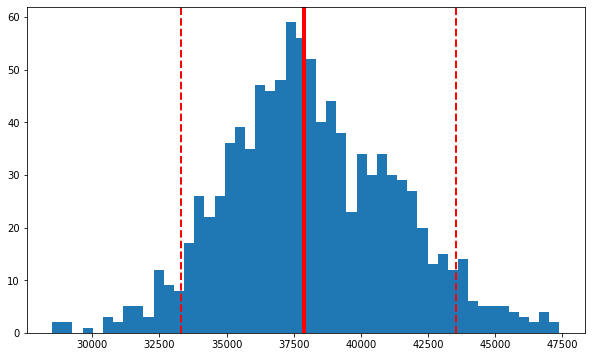

In [38]:
plt.figure(figsize=(10,6))
plt.hist(result,bins=50)
plt.axvline(np.percentile(result,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(result,50), color='r', linestyle='solid', linewidth=4)
plt.axvline(np.percentile(result,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

## Linear Regression

In [39]:
# additional imports
import statsmodels.formula.api as smf
from scipy import stats

In [40]:
# file_path = Path("Project/gdp_data.csv")
file_path = Path("Data/gdp_data.csv")
gdp_data = pd.read_csv(file_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
data = pd.read_csv('Data/gdp_data.csv',index_col=0,usecols=['Date', 'GDP'])

In [41]:
# view concated gdp & indices data.head()
combined_df.head(2)

,SPY,GLD,QQQ,IEF,DIA
2008-01-02,144.55,84.84,50.41,87.65,130.38
2008-01-03,144.46,85.53,50.43,87.77,130.46


In [42]:
combined_df_wgdp = pd.concat([gdp_data, combined_df], axis="columns", join="inner")
combined_df_wgdp.head()

,GDP,SPY,GLD,QQQ,IEF,DIA
2008-04-01,14805.611,136.81,86.880,45.58,90.58,126.42
2008-07-01,14835.187,128.37,92.660,45.83,87.47,113.77
2008-10-01,14559.543,115.99,85.950,38.49,89.25,108.36
2009-04-01,14352.850,81.03,90.980,30.78,96.55,62.07
2009-07-01,14420.312,92.34,92.374,33.12,90.33,85.05


## GDP VS DJIA

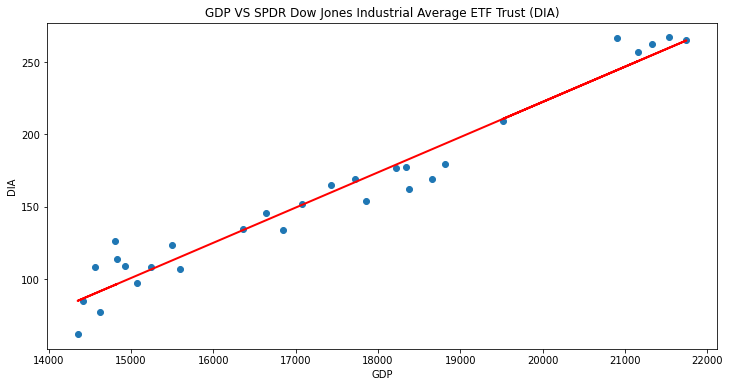

In [43]:
model = smf.ols('DIA ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['DIA'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('DIA')
plt.title('GDP VS SPDR Dow Jones Industrial Average ETF Trust (DIA)')
plt.show()

In [44]:
# set variables
x = combined_df_wgdp['GDP']
y = combined_df_wgdp['DIA']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
future_DJIA = intercept + slope * future_GDP

print("------------------Summary------------------------")
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("------------------Future DJIA--------------------")
print(f"Expected future value of the SPDR Dow Jones Industrial Average ETF Trust (DIA): {round(future_DJIA,2)}")

------------------Summary------------------------
slope: 0.024347    intercept: -264.468478
R-squared: 0.952206
------------------Future DJIA--------------------
Expected future value of the SPDR Dow Jones Industrial Average ETF Trust (DIA): 664.43


## GDP VS S&P 500

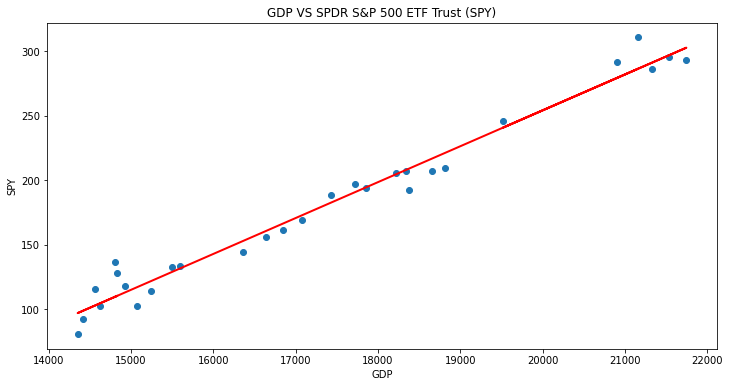

In [45]:
model = smf.ols('SPY ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['SPY'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('SPY')
plt.title('GDP VS SPDR S&P 500 ETF Trust (SPY)')
plt.show()

In [46]:
x = combined_df_wgdp['GDP']
y = combined_df_wgdp['SPY']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("------------------Summary------------------------")
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

print("------------------Future S&P 500--------------------")
future_SP_500 = intercept + slope * future_GDP
print(f"Expected future value of the SPDR S&P 500 ETF Trust (SPY): {round(future_SP_500,2)}")

------------------Summary------------------------
slope: 0.027786    intercept: -301.612307
R-squared: 0.973015
------------------Future S&P 500--------------------
Expected future value of the SPDR S&P 500 ETF Trust (SPY): 758.51


## GDP VS Gold

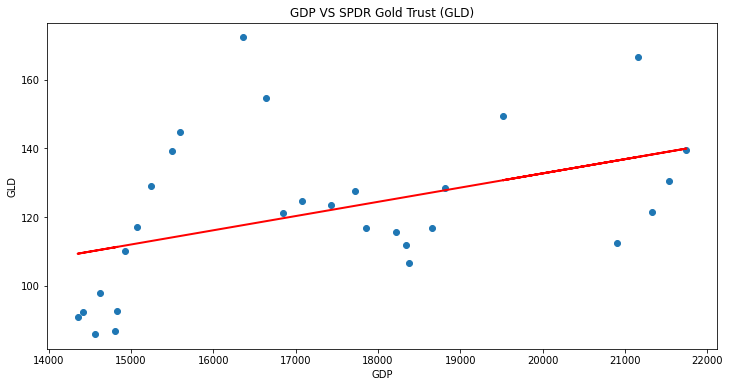

In [47]:
model = smf.ols('GLD ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['GLD'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('GLD')
plt.title('GDP VS SPDR Gold Trust (GLD)')
plt.show()

In [48]:
x = combined_df_wgdp['GDP']
y = combined_df_wgdp['GLD']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("------------------Summary------------------------")
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

print("------------------Future Gold--------------------")
future_Gold = intercept + slope * future_GDP
print(f"Expected future value of the SPDR Gold Trust (GLD): {round(future_Gold,2)}")

------------------Summary------------------------
slope: 0.004142    intercept: 49.874575
R-squared: 0.195046
------------------Future Gold--------------------
Expected future value of the SPDR Gold Trust (GLD): 207.91


## GDP VS NASDAQ

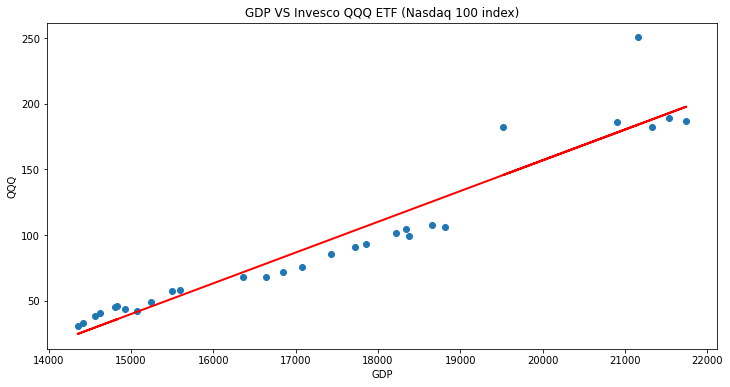

In [49]:
model = smf.ols('QQQ ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['QQQ'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('QQQ')
plt.title('GDP VS Invesco QQQ ETF (Nasdaq 100 index)')
plt.show()

In [50]:
x = combined_df_wgdp['GDP']
y = combined_df_wgdp['QQQ']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("------------------Summary------------------------")
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

print("------------------Future NASDAQ--------------------")
future_NASDAQ = intercept + slope * future_GDP
print(f"Expected future value of the Invesco QQQ ETF (Nasdaq 100 index): {round(future_NASDAQ,2)}")

------------------Summary------------------------
slope: 0.023394    intercept: -310.943366
R-squared: 0.907512
------------------Future NASDAQ--------------------
Expected future value of the Invesco QQQ ETF (Nasdaq 100 index): 581.61


## GDP VS 10 Year UST

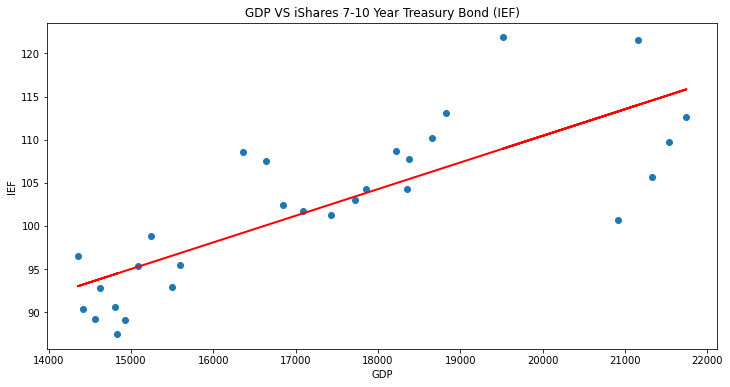

In [51]:
model = smf.ols('IEF ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['IEF'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('IEF')
plt.title('GDP VS iShares 7-10 Year Treasury Bond (IEF)')
plt.show()

In [52]:
x = combined_df_wgdp['GDP']
y = combined_df_wgdp['IEF']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("------------------Summary------------------------")
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

print("------------------Future 10UST--------------------")
future_10UST = intercept + slope * future_GDP
print(f"Expected future value of the iShares 7-10 Year Treasury Bond (IEF): {round(future_10UST,2)}")

------------------Summary------------------------
slope: 0.003088    intercept: 48.684453
R-squared: 0.634903
------------------Future 10UST--------------------
Expected future value of the iShares 7-10 Year Treasury Bond (IEF): 166.5


## Portfolios

In [53]:
# Create closing prices dataframe
df_closing_prices = pd.DataFrame()

df_closing_prices["SPY"] = df_ticker["SPY"]["close"]
df_closing_prices["DIA"] = df_ticker["DIA"]["close"]
df_closing_prices["QQQ"] = df_ticker["QQQ"]["close"]
df_closing_prices["GLD"] = df_ticker["GLD"]["close"]
df_closing_prices["IEF"] = df_ticker["IEF"]["close"]

In [54]:
# calculate daily returns and dropna
df_daily_returns = df_closing_prices.pct_change().dropna()

# display head
df_daily_returns.head()

,SPY,DIA,QQQ,GLD,IEF
2008-01-03,-0.000623,0.000614,0.000397,0.008133,0.001369
2008-01-04,-0.024436,-0.241607,-0.042633,-0.004911,0.002507
2008-01-07,0.003761,0.296341,-0.002278,-0.003995,0.002728
2008-01-08,-0.018733,-0.242554,-0.024704,0.023593,0.001813
2008-01-09,0.014192,0.008749,0.020434,-0.002651,-0.001584


In [55]:
# display df daily returns description
df_daily_returns.describe()

,SPY,DIA,QQQ,GLD,IEF
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,0.000339,0.004237,0.000782,0.000292,0.000106
std,0.013159,0.090370,0.022969,0.011432,0.004258
min,-0.116340,-0.249346,-0.125748,-0.087751,-0.024658
25%,-0.004056,-0.010737,-0.005044,-0.005097,-0.002398
50%,0.000627,0.000810,0.001082,0.000493,0.000230
75%,0.005783,0.012469,0.007487,0.005906,0.002573
max,0.114968,0.433997,0.155200,0.115460,0.035144


<AxesSubplot:ylabel='Density'>

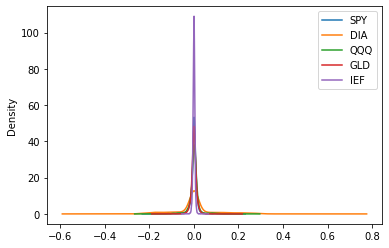

In [56]:
# plot daily returns density
df_daily_returns.plot.density()

In [57]:
# set weights for aggressive portfolio
aggressive_weights = [0.25, 0.25, 0.25, 0.20, 0.05]
portfolio_returns_aggressive = df_daily_returns.dot(aggressive_weights)

In [58]:
# set weights for moderate portfolio
moderate_weights = [0.16, 0.17, 0.17, 0.40, 0.10]
portfolio_returns_moderate = df_daily_returns.dot(moderate_weights)

In [59]:
# set weights for conservative portfolio
conservative_weights = [0.083, 0.083, 0.084, .6, 0.15]
portfolio_returns_conservative = df_daily_returns.dot(conservative_weights)

In [60]:
cumulative_returns_aggressive = (1+portfolio_returns_aggressive).cumprod()
cumulative_returns_moderate = (1+portfolio_returns_moderate).cumprod()
cumulative_returns_conservative = (1+portfolio_returns_conservative).cumprod()

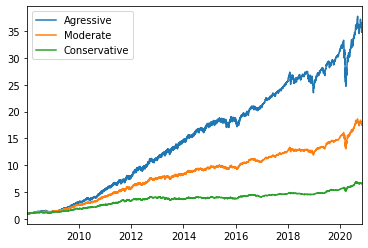

In [61]:
# plot returns for portfolios
basePlot = cumulative_returns_aggressive.plot()
cumulative_returns_moderate.plot(ax=basePlot)
cumulative_returns_conservative.plot(ax=basePlot)
basePlot.legend(["Agressive",'Moderate',"Conservative"]);